In [2]:
#Importing the libraries

import numpy as np
from matplotlib import pyplot
from keras.datasets import fashion_mnist

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [ ]:
!nvidia-smi

Sun Feb 20 08:54:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    77W / 149W |    145MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
import numpy as np

# def sig(x):
#     if(x>=0):
#         return 1/(1 + np.exp(-x))
#     else:
#         return np.exp(x)/(1 + np.exp(x))
def sig(x):
    si = np.where(x < 0, np.exp(x)/(1 + np.exp(x)), 1/(1 + np.exp(-x)))
    return si

def d_sig(x):
    return (1 - sig(x)) * sig(x)

def tanh(x):
    return np.tanh(x)

def d_tanh(x):
    return 1 - np.square(np.tanh(x))

def softmax(x):
    shift = x - np.max(x)
    exps = np.exp(shift)
    return exps / np.sum(exps)

def soft_derv(y, x):     # y = target o/p (one-hot), x = preactivation value
    shift = x - np.max(x)
    exps = np.exp(shift)
    yh = exps / np.sum(exps)
    return (yh-y)
    
# Loss Functions 
def cross_enloss(y, yh):
    loss = -(y*np.log(yh))
    return np.sum(loss)

def d_cross(y, yh):
    return -(y*(1/yh))


#-- Helper Functions --------------------------

def oneHotEnc(Y, num_class):
    Yenc = np.zeros((num_class, int(Y.shape[0])))
    for i in range(Y.shape[0]):
        val = Y[i]
        Yenc[int(val)][i] = 1.0
    return Yenc

In [4]:
# The layer class
class Layer:

    actFun = {
        'tanh': (tanh, d_tanh),
        'sigmoid': (sig, d_sig),
        'softmax': (softmax, soft_derv)
    }
    

    def __init__(self, inputs, neurons, activation, eta, op=False):
        self.eta = eta
        self.op = op
        self.W = np.random.randn(neurons, inputs)
        self.b = np.random.randn(neurons,1)
        self.f, self.der = self.actFun.get(activation)
    
    def feed(self, inps):
        pA = np.matmul(self.W,inps) + self.b
        A = self.f(pA)
        return A
    
    def feedforward(self, inps):
        self.inps = inps
        self.preAct = np.matmul(self.W, self.inps) + self.b
        self.Act = self.f(self.preAct)
        return self.Act
    
    def reset_grad(self):
        self.dW = np.zeros((int(self.W.shape[0]), int(self.W.shape[1]) ))
        self.db = np.zeros((len(self.b), 1))
        
        
    #der(self.preAct) = derv of Activation wrt preActivation at a layer
    #delA = derv of loss w.r.t [activation] (returned back from next/right layer)
    #delPA = derv of loss wrt preAct
    
    def calc_grad(self, delA, y = np.array([[]]) ):
        if self.op == True:
            delPA = self.der(y, self.preAct)
        else:
            delPA = np.multiply(self.der(self.preAct), delA)
        
        delPA = delPA.reshape(len(delPA), 1)
        dW = np.matmul(delPA, self.inps.T)
        db = delPA
        dA_prev = np.matmul(self.W.T, delPA) #derivative of error w.r.t to activations at previous layer
        
        self.dW = self.dW + dW
        self.db = self.db + db
        
        return dA_prev
    
    def update_grad(self):
        self.W = self.W-(self.eta*self.dW)
        self.b = self.b-(self.eta*self.db)


In [13]:
class network:

    def __init__(self, n_layers, neuron_list, act_list, X, Y, eta):
        self.X = X
        self.Y = Y
        self.layers = [Layer(X.shape[0], neuron_list[0], act_list[0],eta)]
        for i in range(1, n_layers):
            if i == (n_layers-1):
                self.layers.append( Layer(neuron_list[i-1], neuron_list[i], act_list[i], eta,True) )  #set layers of network
            else:
                self.layers.append( Layer(neuron_list[i-1], neuron_list[i], act_list[i], eta) )  #set layers of network
        
        
    def train_sgd(self, epochs):
        losses = []
        for epoch in range(epochs):
            i=0
            loss = 0
            for x,y in zip(self.X.transpose(),self.Y.transpose()):
                #feedforward
                y = y.reshape(len(y),1)
                inp = x.reshape(len(x),1)
                for layer in self.layers:
                    inp = layer.feedforward(inp)
                
                yh = inp
                
                loss = loss + cross_enloss(y, yh)
                
                delA = yh
                for layer in reversed(self.layers):
                    ######################################
                    layer.reset_grad()    #reset gradients
                    
                    if(layer.op==True):
                        delA = layer.calc_grad(delA, y)
                    else:
                        delA = layer.calc_grad(delA)
                        
                    layer.update_grad()   #
                    #####################################
                # i = i+1
                # if(i%18000==0):
                #     print("%d dp complete !" %(i,))

            loss = loss/54000
            losses.append(loss)
            print("%d Complete. Loss = %f" %(epoch, losses[-1],))
        print("Update complete. Total epochs = %d" %(epochs,))
        return losses
    
    def classify(self, Xtest):
        pred = []
        for x in Xtest.transpose():
            yh = x.reshape(len(x),1)
            
            #feeding forward without saving
            for layer in self.layers:
                yh = layer.feed(yh)
                
            pred.append(yh.T)
        
        return pred

In [6]:
#data extraction and preprocessing

# load dataset
(trainX, trainy), (testX, testy) = fashion_mnist.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

# # plot first few images
# for i in range(9):
#     # define subplot
#     pyplot.subplot(330 + 1 + i)
#     # plot raw pixel data
#     pyplot.imshow(trainX[i], cmap=pyplot.get_cmap('gray'))
# # show the figure
# pyplot.show()

4431872/4422102 [==============================] - 0s 0us/step
Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


In [7]:
print(type(trainy))
print(trainy.shape)

<class 'numpy.ndarray'>
(60000,)


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

trainX = trainX.reshape(trainX.shape[0], 784)
testX = testX.reshape(testX.shape[0], 784)

trainX = trainX/255.0
testX = testX/255.0

X_train, X_val, y_train, y_val = train_test_split(trainX, trainy, test_size=0.1, random_state=45)

print(X_train.shape + X_val.shape + y_train.shape + y_val.shape)

X_train = X_train.transpose()
X_val = X_val.transpose()
print("X shapes %s %s " %(X_train.shape, X_val.shape,))

ytrain_oneHot = oneHotEnc(y_train,10)
yval_oneHot = oneHotEnc(y_val,10)

print("y shapes %s %s" %(ytrain_oneHot.shape, yval_oneHot.shape,))

(54000, 784, 6000, 784, 54000, 6000)
X shapes (784, 54000) (784, 6000) 
y shapes (10, 54000) (10, 6000)


In [9]:
print(y_train[4])

7


In [14]:
n_layers = 3+1
neuron_list = [32,24,16,10]
act_list = ['sigmoid','sigmoid','sigmoid','softmax']
eta = 0.01
fist = network(n_layers, neuron_list, act_list, X_train, ytrain_oneHot, eta)

In [15]:
fist.layers[0].W

array([[ 0.03560206, -0.46593235,  0.26164112, ...,  0.97923188,
        -0.33687347,  1.47017776],
       [-2.07309419, -1.17017467,  0.40638532, ..., -0.2211126 ,
         1.25721138,  1.75261035],
       [ 0.69410981, -1.55135301, -0.95136623, ..., -1.55590537,
         0.44168032, -0.9701924 ],
       ...,
       [-0.29864666,  1.17703771, -1.17508075, ...,  0.60123539,
         1.16689735, -0.16308955],
       [ 0.54808788, -0.19560905, -0.64641002, ...,  1.36579199,
        -0.26457426, -0.4199928 ],
       [ 0.0751581 , -0.25673442, -1.00332772, ..., -0.11020438,
         0.1229497 , -0.20227912]])

In [12]:
for i in range(4):
    print(fist.layers[i].W.shape)

(32, 784)
(24, 32)
(16, 24)
(10, 16)


In [16]:
losses = fist.train_sgd(100)

0 Complete. Loss = 0.944674
1 Complete. Loss = 0.618314
2 Complete. Loss = 0.551975
3 Complete. Loss = 0.514876
4 Complete. Loss = 0.490461
5 Complete. Loss = 0.471968
6 Complete. Loss = 0.456089
7 Complete. Loss = 0.442512
8 Complete. Loss = 0.430935
9 Complete. Loss = 0.420980
10 Complete. Loss = 0.411883
11 Complete. Loss = 0.403897
12 Complete. Loss = 0.396489
13 Complete. Loss = 0.389671
14 Complete. Loss = 0.383540
15 Complete. Loss = 0.377910
16 Complete. Loss = 0.372649
17 Complete. Loss = 0.367531
18 Complete. Loss = 0.362683
19 Complete. Loss = 0.358275
20 Complete. Loss = 0.354101
21 Complete. Loss = 0.350057
22 Complete. Loss = 0.346260
23 Complete. Loss = 0.342671
24 Complete. Loss = 0.339278
25 Complete. Loss = 0.336006
26 Complete. Loss = 0.332849
27 Complete. Loss = 0.329901
28 Complete. Loss = 0.327009
29 Complete. Loss = 0.324285
30 Complete. Loss = 0.321686
31 Complete. Loss = 0.319205
32 Complete. Loss = 0.316748
33 Complete. Loss = 0.314469
34 Complete. Loss = 0.31

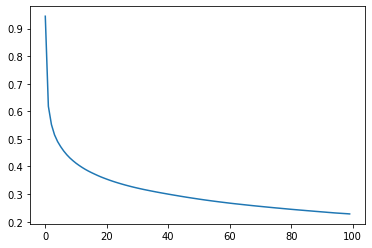

In [19]:
import matplotlib.pyplot as plt
plt.plot(range(100), losses)
plt.show()

In [20]:
val_pred = fist.classify(X_val)

In [34]:
# print(np.argmax(val_pred.transpose()[1]))
# print(y_train[1])
count = 0
for i in range(6000):
    if(np.argmax(val_pred[i])==y_val[i]):
      count = count+1
print(count*100/6000)

85.91666666666667
